<a href="https://colab.research.google.com/github/martings/ML_Practica_y_Herramientas/blob/main/redes_neuronales_mirando_abajo_del_capo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/notebooks/notebook_09_redes_neuronales-published.ipynb)

# Redes neuronales


Vamos nuevamente a trabajar con los datos de `iris` para entrenar (y antes construir) una Red Neuronal.

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt

def get_data():
    dataset = load_iris()
    X = dataset["data"]
    y = dataset["target"]
    y = LabelEncoder().fit_transform(y)
    return np.array(X), np.array(y)
X, y = get_data()
X[:10]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1]])

La propuesta es empezar por el esqueleto de las 2 clases que usaremos para esta tarea e ir implementado los métodos a medida que avancemos.

Al final de este notebook se encuentran ambas clases completas. Pueden copiar el código desde allí mismo o implementarlo. La idea es que en cada avance podamos comprender la parte del proceso que estamos realizando, por lo cual se recomienda seguir la guia propuesta e ir completando sólo lo que es necesario para cada punto.

Defino la clase capa (layer), cada capa consta de su valor, el input, el peso asociado, el bias y que tipo de activacion (ReLU y SOFTMAX).


In [41]:
class Capa:
    def __init__(self, neuronas):
        self.neuronas = neuronas

    def forward(self, inputs, weights, bias, activation):
        """
        Forward Propagation de la capa
        """
        Z_curr = np.dot(inputs, weights.T) + bias

        if activation == 'relu':
            A_curr = self.relu(inputs=Z_curr)
        elif activation == 'softmax':
            A_curr = self.softmax(inputs=Z_curr)

        return A_curr, Z_curr

    def relu(self, inputs):
        """
        ReLU: función de activación
        """

        return np.maximum(0, inputs)

    def softmax(self, inputs):
        """
        Softmax: función de activación
        """
        exp_scores = np.exp(inputs)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs
         
    def backward(self, dA_curr, W_curr, Z_curr, A_prev, activation):
        """
        Backward Propagation de la capa
        """
        if activation == 'softmax':
            dW = np.dot(A_prev.T, dA_curr)
            db = np.sum(dA_curr, axis=0, keepdims=True)
            dA = np.dot(dA_curr, W_curr) 
        else:
            dZ = self.relu_derivative(dA_curr, Z_curr)
            dW = np.dot(A_prev.T, dZ)
            db = np.sum(dZ, axis=0, keepdims=True)
            dA = np.dot(dZ, W_curr)
            
        return dA, dW, db

    def relu_derivative(self, dA, Z):
        """
        ReLU: gradiente de ReLU
        """
        dZ = np.array(dA, copy = True)
        dZ[Z <= 0] = 0
        return dZ
    

Defino la clase RedNeuronal.

In [42]:
class RedNeuronal:
    def __init__(self, learning_rate=0.01):
        self.red = [] ## capas
        self.arquitectura = [] ## mapeo de entradas -> salidas
        self.pesos = [] ## W, b
        self.memoria = [] ## Z, A
        self.gradientes = [] ## dW, db
        self.lr = learning_rate
        
    def add(self, capa):
        """
        Agregar capa a la red
        """
        self.red.append(capa)
            
    def _compile(self, data):
        """
        Inicializar la arquitectura
        """
        for idx, _ in enumerate(self.red):
            if idx == 0:
                self.arquitectura.append({'input_dim': data.shape[1], 
                                        'output_dim': self.red[idx].neuronas,
                                        'activation':'relu'})
            elif idx > 0 and idx < len(self.red)-1:
                self.arquitectura.append({'input_dim': self.red[idx-1].neuronas, 
                                        'output_dim': self.red[idx].neuronas,
                                        'activation':'relu'})
            else:
                self.arquitectura.append({'input_dim': self.red[idx-1].neuronas, 
                                        'output_dim': self.red[idx].neuronas,
                                        'activation':'softmax'})
        return self

    def _init_weights(self, data):
        """
        Inicializar arquitectura y los pesos
        """
        self._compile(data)

        np.random.seed(99)

        for i in range(len(self.arquitectura)):
            self.pesos.append({
                'W':np.random.uniform(low=-1, high=1, 
                        size=(self.arquitectura[i]['input_dim'],
                            self.arquitectura[i]['output_dim']
                            )),
                'b':np.zeros((1, self.arquitectura[i]['output_dim']))})

        return self
    
    def _forwardprop(self, data):
        """
        Pasada forward completa por la red
        """
        A_curr = data

        for i in range(len(self.pesos)):
            A_prev = A_curr
            A_curr, Z_curr = self.red[i].forward(inputs=A_prev, weights=self.pesos[i]['W'].T,
                                                 bias=self.pesos[i]['b'],activation=self.arquitectura[i]['activation'])
            self.memoria.append({'inputs':A_prev, 'Z':Z_curr})

        return A_curr
    
    def _backprop(self, predicted, actual):
        """
        Pasada backward completa por la red
        """
        num_samples = len(actual)

        ## compute the gradient on predictions
        dscores = predicted
        dscores[range(num_samples),actual] -= 1
        dscores /= num_samples

        dA_prev = dscores

        for idx, layer in reversed(list(enumerate(self.red))):
            dA_curr = dA_prev

            A_prev = self.memoria[idx]['inputs']
            Z_curr = self.memoria[idx]['Z']
            W_curr = self.pesos[idx]['W']

            activation = self.arquitectura[idx]['activation']

            dA_prev, dW_curr, db_curr = layer.backward(dA_curr, W_curr.T, Z_curr, A_prev, activation)

            self.gradientes.append({'dW':dW_curr, 'db':db_curr})

        self.gradientes = list(reversed(self.gradientes))  # Reverse the gradients list

    def _update(self):
        """
        Actualizar el modelo --> lr * gradiente
        """
        lr = self.lr
        for idx, layer in enumerate(self.red):
            self.pesos[idx]['W'] -= lr * self.gradientes[idx]['dW']
            self.pesos[idx]['b'] -= lr * self.gradientes[idx]['db']

    def _get_accuracy(self, predicted, actual):
        """
        Calcular accuracy después de cada iteración
        """
        return np.mean(np.argmax(predicted, axis=1)==actual)
        
    def _calculate_loss(self, predicted, actual):
        """
        Calculate cross-entropy loss after each iteration
        """
        samples = len(actual)

        correct_logprobs = -np.log(predicted[range(samples),actual])
        data_loss = np.sum(correct_logprobs)/samples

        return data_loss

    def train(self, X_train, y_train, epochs):
        """
        Entrenar el modelo Stochastic Gradient Descent
        """
        self.loss = []
        self.accuracy = []

        self._init_weights(X_train)

        for i in range(epochs):
            yhat = self._forwardprop(X_train)
            self.accuracy.append(self._get_accuracy(predicted=yhat, actual=y_train))
            self.loss.append(self._calculate_loss(predicted=yhat, actual=y_train))

            self._backprop(predicted=yhat, actual=y_train)

            self._update()

            if i % 20 == 0:
                s = 'EPOCH: {}, ACCURACY: {}, LOSS: {}'.format(i, self.accuracy[-1], self.loss[-1])
                print(s)

        return (self.accuracy, self.loss)


In [ ]:
Herramienta para graficar las redes neuronales generadas.

In [50]:
from graphviz import Digraph, Graph

def dibujar_red(red):
    dot = Graph()
    dot.attr(rankdir="LR")
    dot.attr(splines="false")
    dot.attr(nodesep="0.05")
    
    for idx,capa in enumerate(red.arquitectura):
        with dot.subgraph(name=f'cluster_{idx}') as c:
            c.attr(rank="same")
            for i in range(capa['input_dim']+1):
                c.node(nombre_nodo(idx, i), label=etiqueta_nodo(idx,i))

            c.attr(color='white')
            
            label_extra = "Entrada" if idx == 0 else "Oculta\n(ReLU)"
        
            c.attr(label=f'capa {idx+1}\n{label_extra}')

    with dot.subgraph(name=f'cluster_{idx+1}') as c:
            c.attr(rank="same")
            for i in range(capa['output_dim']):
                c.node(nombre_nodo(idx+1, i), label=etiqueta_nodo(idx+1,i, True))

            c.attr(color='white')
            
            label_extra = "Salida\n(SoftMax)"
        
            c.attr(label=f'capa {idx+1}\n{label_extra}')

    for idx, capa in enumerate(red.arquitectura):
        for in_idx in range(capa["input_dim"]+1):
            for out_idx in range(capa["output_dim"]):
                to_node = (idx+1, out_idx+1) if idx!=len(red.arquitectura)-1 else (idx+1, out_idx)
                dot.edge(nombre_nodo(idx, in_idx), 
                         nombre_nodo(*to_node))

    return dot

def nombre_nodo(capa, indice):
    res = f"c_{capa}_{indice}"
    return res

def etiqueta_nodo(capa, indice, es_final=False):
    if indice==0 and not es_final:
        return "1"
    l = "a" if capa!=0 else "x"
    l = l if not es_final else "y"
    
    if l=="x" or l=="y":    
        return f"<{l}<sub>{indice}</sub>>"
    else:
        return f"<{l}<sub>{indice}</sub><sup>({capa})</sup>>"

# model = RedNeuronal()
# model.add(...)
# model._compile(...datos...)


Los items que se presentan a continuación tienen como objetvio explorar las clases que componen la red neuronal propuesta, comprender su arquitectura y funcionamiento.

Nuevamente, lo ideal es no mirar todos los métodos hasta que llegue el momento de utilizarlos. 

1. Crear una Red Neuronal con 6 nodos en la primera capa, 8 en la segunda, 10 en la tercer y finalmente 3 en la última, utilizando los métodos `add()`, `_compile()` de la clase `RedNeuronal` y el constructor de la clase `Capa`.
  
    Imprimir la arquitectura del modelo y asegurarse de obtener:

    ```
    [{'input_dim': 4, 'output_dim': 6, 'activation': 'relu'},
    {'input_dim': 6, 'output_dim': 8, 'activation': 'relu'},
    {'input_dim': 8, 'output_dim': 10, 'activation': 'relu'},
    {'input_dim': 10, 'output_dim': 3, 'activation': 'softmax'}]
    ```

    Dibujar la red en papel.

In [11]:
X.shape[1]

4

In [45]:
#Inicializo la red neuronal
red= RedNeuronal()
#Le agrego las capas 
red.add(Capa(6))
red.add(Capa(8))
red.add(Capa(10))
red.add(Capa(3))
#Compilo
red._compile(X)
#Chequeo la arquitectura
print(red.arquitectura)

[{'input_dim': 4, 'output_dim': 6, 'activation': 'relu'}, {'input_dim': 6, 'output_dim': 8, 'activation': 'relu'}, {'input_dim': 8, 'output_dim': 10, 'activation': 'relu'}, {'input_dim': 10, 'output_dim': 3, 'activation': 'softmax'}]


1. Inicializar los pesos de la red del punto anterior (`_init_weights(datos)`) y verificar que los pesos tienen dimensión correcta:

    ```
    capa 0: w=(4, 6) - b=(1, 6)
    capa 1: w=(6, 8) - b=(1, 8)
    capa 2: w=(8, 10) - b=(1, 10)
    capa 3: w=(10, 3) - b=(1, 3)
    ```

    Definir las matrices que se corresponden con las capas de manera que una pasada pueda ser interpretada como el producto de todas ellas. Recordar que en cada paso por cada capa estaremos computando por cada neurona de la capa siguiente:


  $$Z = \sum_{i=1}^{n} X_i \times W_i + b$$


In [46]:
red._init_weights(X)
#Capa 0
print(red.pesos[0]['W'].shape, red.pesos[0]['b'].shape)
#Capa 1
print(red.pesos[1]['W'].shape, red.pesos[1]['b'].shape)
#Capa 2
print(red.pesos[2]['W'].shape, red.pesos[2]['b'].shape)
#Capa 3
print(red.pesos[3]['W'].shape, red.pesos[3]['b'].shape)

(4, 6) (1, 6)
(6, 8) (1, 8)
(8, 10) (1, 10)
(10, 3) (1, 3)


1. Funciones de activación de una `Capa`:

    1. Verificar que el funcionamiento de `ReLU` se corresponda con:

        ```
        if input > 0:
            return input
        else:
            return 0
        ``` 

    1. Verificar que el funcionamiento de `softmax` se corresponda con:

  $$\sigma(Z)_i = \frac{e^{z_i}}{\sum_{i=1}^{n} e^{z_j}}$$

    **Nota**: para probar estos dos métodos puede ser util construir un vector de la siguiente manera: `np.array([[1.3, 5.1, -2.2, 0.7, 1.1]])` que genera un vector de tamaño (1,5).

1. Avancemos con `_forwardprop(datos)`, si corremos la red inicializada con los datos:

    1. ¿Qué nos tipo de objeto nos devuelve este método?

    1. ¿Qué quiere decir cada uno de los valores?

    1. La primera fila, que se correspondería con la primera observación del dataset, ¿qué resultados nos da?¿qué es más probable: 'setosa', 'versicolor' o 'virginica'?¿qué valor es el real?¿por qué?

In [48]:
#Inicializo la red neuronal
red= RedNeuronal()
#Le agrego las capas 
red.add(Capa(6))
red.add(Capa(8))
red.add(Capa(10))
red.add(Capa(3))

red._init_weights(X)
out = red._forwardprop(X)
print(len(red.pesos))
print(len(red.arquitectura))
print('SHAPE:', out.shape)
print('Probabilties at idx 0:', out[0])
print('SUM:', sum(out[0]))

4
4
SHAPE: (150, 3)
Probabilties at idx 0: [0.16617107 0.81859653 0.0152324 ]
SUM: 1.0




1. Arrancamos a propagar para atrás lo aprendido en la primera pasada. Esto lo realizaremos con el método `_backprop`.

    1. ¿Cómo es la derivada de la función de activación `ReLU`?¿Su código es correcto?

    1. ¿Cuál es la operación matemática que hace la función `backward` de la clase `Capa` en el caso de tener como activación a `relu`?

    1. El método `_backprop` toma 2 parámetros: `predicted` y `actual`. ¿qué debemos pasarle en dicho lugar?

        Si la respuesta no fue: en `predicted` le pasamos el resultado de `_forwardprop(...)` y en `actual` le pasamos `y`.... volver a pensarlo. ;-)

    1. Verificar que los `gradientes` y los `pesos` para cada una de las capas tienen el mismo tamaño.

1. Preparemos por último las funciones necesarias para el entrenamiento. Describir brevemente qué hacen las funciones:

    - `_get_accuracy`
    - `_calculate_loss`
    - `_update`

1. Incluyamos finalmente la función `train` y entrenemos una red con la arquitectura propuesta en el punto 1 por 200 epocas.

    1. ¿Qué valores se imprimen?¿Qué es posible interpretar de ellos?

    1. Graficar el _accuracy_ y la _loss_ que arroja el entramiento en función de las _epochs_. ¿Qué se puede concluir? Probablemente la señal sea ruidosa, por lo que se recomienda hacer un suavizado por ventanas deslizantes.


Crédito: este ejercicio se base en la propuesta de Joe Sasson publicada en [Towards Data Science](https://towardsdatascience.com/coding-a-neural-network-from-scratch-in-numpy-31f04e4d605).

In [43]:
len(red.pesos)

4

In [52]:
#Inicializo la red neuronal
red= RedNeuronal()
#Le agrego las capas 
red.add(Capa(6))
red.add(Capa(8))
red.add(Capa(10))
red.add(Capa(3))
#Entreno a la red con un epoch de 200
red.train(X,y,200)

EPOCH: 0, ACCURACY: 0.25333333333333335, LOSS: 2.537401260962661
EPOCH: 20, ACCURACY: 0.3333333333333333, LOSS: 2.560375535104017
EPOCH: 40, ACCURACY: 0.6266666666666667, LOSS: 2.005409652700129
EPOCH: 60, ACCURACY: 0.66, LOSS: 1.6838036216724848
EPOCH: 80, ACCURACY: 0.6333333333333333, LOSS: 1.5293444244585876
EPOCH: 100, ACCURACY: 0.48, LOSS: 1.3522398101899988
EPOCH: 120, ACCURACY: 0.48, LOSS: 1.1284742049684549
EPOCH: 140, ACCURACY: 0.54, LOSS: 0.9497974088127584
EPOCH: 160, ACCURACY: 0.6333333333333333, LOSS: 0.850730658460274
EPOCH: 180, ACCURACY: 0.7266666666666667, LOSS: 0.7717923934635362


([0.25333333333333335,
  0.3333333333333333,
  0.3333333333333333,
  0.013333333333333334,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.31333333333333335,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.36,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.52,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.34,
  0.3333333333333333,
  0.5866666666666667,
  0.3333333333333333,
  0.6533333333333333,
  0.3333333333333333,
  0.6,
  0.3333333333333333,
  0.6466666666666666,
  0.3333333333333333,
  0.6,
  0.3333333333333333,
  0.6266666666666667,
  0.3333333333333333,
  0.6466666666666666,
  0.3333333333333333,
  0.6533333333333333,
  0.3333333333333333,
  0.66,
  0.3333333333333333,
  0.66,
  0.33333333333333

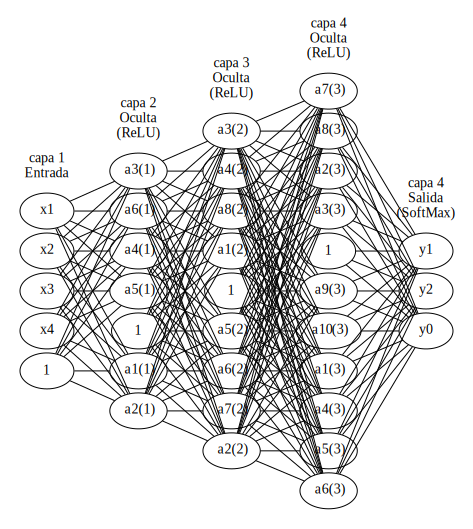

In [53]:
dibujar_red(red)